In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn import set_config
set_config(display='diagram')

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (classification_report, plot_confusion_matrix, 
                            plot_precision_recall_curve, plot_roc_curve)
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# import helper functions
from helpers import filter_top_cats, boolstring_to_int, get_feature_names

# import helper Custom Tranformers
from helpers import DatePrep, TargetEncoder

# Import data

In [4]:
X = pd.read_csv('data/train values.csv', index_col=0)
y = pd.read_csv('data/train labels.csv', index_col=0)
y = y['status_group']
#df = pd.concat([X, y], axis = 1)
X.head()

amount_tsh date_recorded        funder  gps_height     installer  \
id                                                                        
69572      6000.0    2011-03-14         Roman        1390         Roman   
8776          0.0    2013-03-06       Grumeti        1399       GRUMETI   
34310        25.0    2013-02-25  Lottery Club         686  World vision   
67743         0.0    2013-01-28        Unicef         263        UNICEF   
19728         0.0    2011-07-13   Action In A           0       Artisan   

       longitude   latitude              wpt_name  num_private  \
id                                                               
69572  34.938093  -9.856322                  none            0   
8776   34.698766  -2.147466              Zahanati            0   
34310  37.460664  -3.821329           Kwa Mahundi            0   
67743  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
19728  31.130847  -1.825359               Shuleni            0   

                         basin  ... payment_type water_quality  quality_group  \
id                              ...                                             
69572               Lake Nyasa  ...     annually          soft           good   
8776             Lake Victoria  ...    never pay          soft           good   
34310                  Pangani  ...   per bucket          soft           good   
67743  Ruvuma / Southern Coast  ...    never pay          soft           good   
19728            Lake Victoria  ...    never pay          soft           good   

           quantity quantity_group                source  \
id                                                         
69572        enough         enough                spring   
8776   insufficient   insufficient  rainwater harvesting   
34310        enough         enough                   dam   
67743           dry            dry           machine dbh   
19728      seasonal       seasonal  rainwater harvesting   

                source_type source_class              waterpoint_type  \
id                                                                      
69572                spring  groundwater           communal standpipe   
8776   rainwater harvesting      surface           communal standpipe   
34310                   dam      surface  communal standpipe multiple   
67743              borehole  groundwater  communal standpipe multiple   
19728  rainwater harvesting      surface           communal standpipe   

      waterpoint_type_group  
id                           
69572    communal standpipe  
8776     communal standpipe  
34310    communal standpipe  
67743    communal standpipe  
19728    communal standpipe  

[5 rows x 39 columns]

In [5]:
y.head()

id
69572        functional
8776         functional
34310        functional
67743    non functional
19728        functional
Name: status_group, dtype: object

# Pipeline

Copy the pipeline in from the previous lab.

In [6]:
## Continuous columns
cont_cols = ['gps_height', 'construction_year']
continuous_pipeline = Pipeline(
        steps = [
            ('imp', SimpleImputer(missing_values = 0, strategy='median'))
        ])

## Population
population_cols = ['population']
population_pipeline = Pipeline(
        steps = [
            ('imp1', SimpleImputer(missing_values = 1, strategy='constant', fill_value=0)),
            ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
            ('log', FunctionTransformer(np.log))
        ])

## Latitude and Longitude
latlong_cols = ['latitude', 'longitude']
latlong_pipeline = Pipeline(
        steps = [
            # Fill with median for now, will try other strategy in tuning
            ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
            ('imp-0', SimpleImputer(missing_values = -2e-08, strategy='median'))
        ])

## Columns to Log Transform
log_cols = ['amount_tsh', 'num_private']
log_pipeline = Pipeline(
        steps = [
            ('imp', SimpleImputer(missing_values = 0, strategy='median')),
            ('log', FunctionTransformer(np.log))
        ])

## Categorical columns
cat_cols = ['quantity', 'extraction_type_class', 
            'water_quality', 'source', 'source_type', 'scheme_name', 
            'source_class', 'management_group', 
            'payment_type', 'basin', 'payment', 'quality_group', 
            'waterpoint_type', 'management', 'region', #'district_code', 
            'scheme_management', 'installer']
cat_pipeline = Pipeline(
        steps = [
            # most_frequent is impossibly slow
            # ('imp', SimpleImputer(strategy='most_frequent')),
            ('imp', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('reduce', FunctionTransformer(func = filter_top_cats, 
                                           kw_args={'t':.05, 'method':'percent'})),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
        ])


## Bool columns
bool_cols = ['public_meeting', 'permit']
bool_pipeline = Pipeline(
        steps = [
            ('imp', SimpleImputer(strategy='median')),
            ('bool', FunctionTransformer(boolstring_to_int))
        ])


## Date columns
date_cols = ['date_recorded', 'construction_year']
date_pipeline = Pipeline(
        steps = [
            ('date', DatePrep(strategy = 'median'))
        ])


## Main Column Transformer
ct = ColumnTransformer(
    transformers = [
        ('cont', continuous_pipeline, cont_cols),
        ('pop', population_pipeline, population_cols),
        ('latlong', latlong_pipeline, latlong_cols),
        ('log', log_pipeline, log_cols),
        ('cats', cat_pipeline, cat_cols),
        ('bool', bool_pipeline, bool_cols),
        ('date', date_pipeline, date_cols)
    ],
    #remainder='passthrough'
)

ct.fit_transform(X, y)

#get_feature_names(ct)

result = ct.fit_transform(X, y)
df_tx = pd.DataFrame(result, columns=get_feature_names(ct))
df_tx.head()

cont__gps_height  cont__construction_year  pop__population  \
0            1390.0                   1999.0         4.691348   
1            1399.0                   2010.0         5.634790   
2             686.0                   2009.0         5.521461   
3             263.0                   1986.0         4.060443   
4            1167.0                   2000.0         5.298317   

   latlong__latitude  latlong__longitude  log__amount_tsh  log__num_private  \
0          -9.856322           34.938093         8.699515           2.70805   
1          -2.147466           34.698766         5.521461           2.70805   
2          -3.821329           37.460664         3.218876           2.70805   
3         -11.155298           38.486161         5.521461           2.70805   
4          -1.825359           31.130847         5.521461           2.70805   

   onehot__x0_dry  onehot__x0_enough  onehot__x0_insufficient  ...  \
0             0.0                1.0                      0.0  ...   
1             0.0                0.0                      1.0  ...   
2             0.0                1.0                      0.0  ...   
3             1.0                0.0                      0.0  ...   
4             0.0                0.0                      0.0  ...   

   onehot__x15_Water authority  onehot__x15_other  onehot__x15_unknown  \
0                          0.0                0.0                  0.0   
1                          0.0                1.0                  0.0   
2                          0.0                0.0                  0.0   
3                          0.0                0.0                  0.0   
4                          0.0                0.0                  1.0   

   onehot__x16_DWE  onehot__x16_other  onehot__x16_unknown  \
0              0.0                1.0                  0.0   
1              0.0                1.0                  0.0   
2              0.0                1.0                  0.0   
3              0.0                1.0                  0.0   
4              0.0                1.0                  0.0   

   bool__public_meeting  bool__permit  date__date_recorded  \
0                   1.0           0.0              15047.0   
1                   1.0           1.0              15770.0   
2                   1.0           1.0              15761.0   
3                   1.0           1.0              15733.0   
4                   1.0           1.0              15168.0   

   date__construction_year  
0                     12.0  
1                      3.0  
2                      4.0  
3                     27.0  
4                     11.0  

[5 rows x 92 columns]

# Class imbalnce

<AxesSubplot:xlabel='status_group', ylabel='count'>

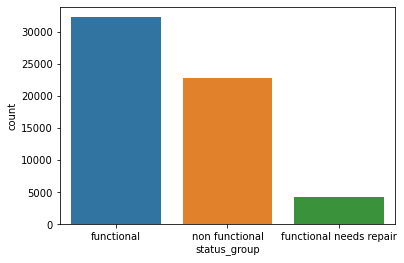

In [7]:
sns.countplot(x=y)

In [8]:
smote_pipe = IMBPipeline(
                steps = [('prep', ct),
                         ('smote', SMOTE())]
)

In [9]:
%%timeit -n1 -r1
smote_pipe.fit(X, y)
xs, ys = smote_pipe.fit_resample(X, y)

14.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Downsample

At almost 8 seconds per fold this is going to take a long time optimize our models with grid search if we include SMOTE in the pipeline with all of our data.

We do want to tune the parameters of our pipeline, but for for practical reasons (time) we have to compromise something.  We can:
* Work with preprocessed data for most iterations, then switch to our pipelie to tune the models there.
* We can iterate our models with a subset of our data.

Test to see how long it would take on only 5k samples

In [10]:
# Get a much smaller dataset to workwith for faster iterating.
X_small, X_test, y_small, y_test = train_test_split(X, y, 
                                                    test_size=5000, 
                                                    train_size=5000,
                                                    random_state=594)


In [11]:
%%timeit -n1 -r1
smote_pipe.fit(X_small, y_small)
Xs, ys = smote_pipe.fit_resample(X_small, y_small)

1.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


< 1 second is workable and we can tune all of our hyper parameters including our pipeline params in the same way!

In [12]:
y_small.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

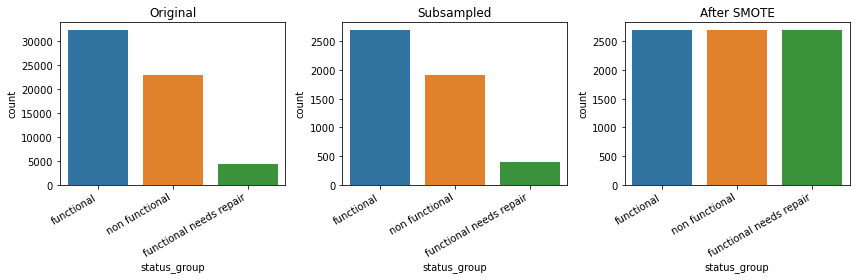

In [13]:
# check the balance before and after smote
smote_pipe.fit(X_small, y_small)
Xs, ys = smote_pipe.fit_resample(X_small, y_small)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

order = y.unique()
sns.countplot(x=y, order=order, ax = ax1)
ax1.set_title('Original')
ax1.set_xticklabels(order, rotation=30, ha='right')

sns.countplot(x=y_small, order=order,ax = ax2)
ax2.set_title('Subsampled')
ax2.set_xticklabels(order, rotation=30, ha='right')

sns.countplot(x=ys, order=order, ax =ax3)
ax3.set_title('After SMOTE')
ax3.set_xticklabels(order, rotation=30, ha='right')


fig.tight_layout()

# Helpers
## Results Class

In [14]:
class Results:
    def __init__(self):
        self.estimation_columns = ['estimator', 'params', 'score']
        self.estimations = {}
        self.estimators = {}
    
    def store_gs_result(self, gs):
        name = gs.best_estimator_[-1].__class__.__name__ + '('
        
        for key, value in gs.best_params_.items():
            name += key + ' = ' + str(value) + ', '
            
        if len(gs.best_params_) > 0:
            name = name[:-2] # chop the last comma
        
        name += ')'
        
        self.estimations[name] = {'score' : gs.best_score_}
        self.estimators[name] = gs.best_estimator_
        
    def results_df(self):
        return pd.DataFrame.from_dict(self.estimations).T

In [15]:
# Initialize GridSearch Results Object
gs_results = Results()

## do_gs function

In [16]:
def do_gs(model, param_grid, search_type = 'grid', X=X_small, y=y_small):
    
    scoring = 'recall_macro' # In case we want to try tracking multiple metrics.
        
    if search_type == 'random':
        gs = RandomizedSearchCV(model, param_grid, scoring=scoring, cv=3) 
    else:
        gs = GridSearchCV(model, param_grid, scoring=scoring, cv=3) 
    
    gs.fit(X, y)

    print("Best parameter (CV score=%0.3f):" % gs.best_score_)
    #display(gs.best_params_)
    
    print(classification_report(y_test, gs.predict(X_test)))
    plot_confusion_matrix(gs, X_test, y_test)
    plt.xticks(rotation = 45, ha='right');
    
    #print('Storing Results....')
    gs_results.store_gs_result(gs)
    
    return gs

## display_new_params
For displaying on the parameters that changed in the new model from the last

In [17]:
# show only the new parameters
def display_new_params(model, last_model):

    def stringify(tuples):
        return [(str(x[0]), str(x[1])) for x in tuples]
    
    mp = set(stringify(model.best_params_.items()))
    lmp = set(stringify(last_model.best_params_.items()))
    new = mp.difference(lmp)
    for key, value in sorted(new, key=lambda x: x[0]):
        print(key, ' : ', value)
    if len(new) == 0:
        print('No parameter changes')
        
#display_new_params(model, last_model)

# KNN

In [18]:
knn_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('knn', KNeighborsClassifier())
])

knn_clf_ns = Pipeline(steps = [
    ('prep', ct),
    ('knn', KNeighborsClassifier(weights='uniform'))
])#knn_clf = pipe

In [19]:
knn_clf.fit(X_small, y_small)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(missing_values=0,
                                                                                 strategy='median'))]),
                                                  ['gps_height',
                                                   'construction_year']),
                                                 ('pop',
                                                  Pipeline(steps=[('imp1',
                                                                   SimpleImputer(fill_value=0,
                                                                                 missing_values=1,
                                                                                 strategy='constant')),
                                                                  ('imp0',
                                                                   SimpleImputer(missing_values=0,
                                                                                 strategy='median')),
                                                                  ('log',
                                                                   FunctionTra...
                                                   'management', 'region',
                                                   'scheme_management',
                                                   'installer']),
                                                 ('bool',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('bool',
                                                                   FunctionTransformer(func=<function boolstring_to_int at 0x124dd75e0>))]),
                                                  ['public_meeting', 'permit']),
                                                 ('date',
                                                  Pipeline(steps=[('date',
                                                                   DatePrep())]),
                                                  ['date_recorded',
                                                   'construction_year'])])),
                ('smote', SMOTE()), ('knn', KNeighborsClassifier())])

In [20]:
knn_clf_ns.fit(X_small, y_small)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(missing_values=0,
                                                                                 strategy='median'))]),
                                                  ['gps_height',
                                                   'construction_year']),
                                                 ('pop',
                                                  Pipeline(steps=[('imp1',
                                                                   SimpleImputer(fill_value=0,
                                                                                 missing_values=1,
                                                                                 strategy='constant')),
                                                                  ('imp0',
                                                                   SimpleImputer(missing_values=0,
                                                                                 strategy='median')),
                                                                  ('log',
                                                                   FunctionTra...
                                                   'waterpoint_type',
                                                   'management', 'region',
                                                   'scheme_management',
                                                   'installer']),
                                                 ('bool',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('bool',
                                                                   FunctionTransformer(func=<function boolstring_to_int at 0x124dd75e0>))]),
                                                  ['public_meeting', 'permit']),
                                                 ('date',
                                                  Pipeline(steps=[('date',
                                                                   DatePrep())]),
                                                  ['date_recorded',
                                                   'construction_year'])])),
                ('knn', KNeighborsClassifier())])

## Initial with SMOTE

Best parameter (CV score=0.486):
                         precision    recall  f1-score   support

             functional       0.67      0.57      0.61      2686
functional needs repair       0.17      0.48      0.25       365
         non functional       0.58      0.51      0.54      1949

               accuracy                           0.54      5000
              macro avg       0.47      0.52      0.47      5000
           weighted avg       0.60      0.54      0.56      5000



score
KNeighborsClassifier()  0.485772

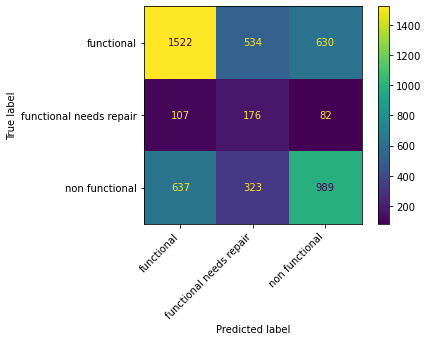

In [21]:
param_grid = {}
gs = do_gs(knn_clf, param_grid)
gs_results.results_df()

## Initial without SMOTE

Best parameter (CV score=0.440):
                         precision    recall  f1-score   support

             functional       0.64      0.78      0.70      2686
functional needs repair       0.30      0.18      0.23       365
         non functional       0.61      0.48      0.54      1949

               accuracy                           0.62      5000
              macro avg       0.52      0.48      0.49      5000
           weighted avg       0.60      0.62      0.60      5000



score
KNeighborsClassifier()                        0.485772
KNeighborsClassifier(knn__weights = uniform)  0.439856

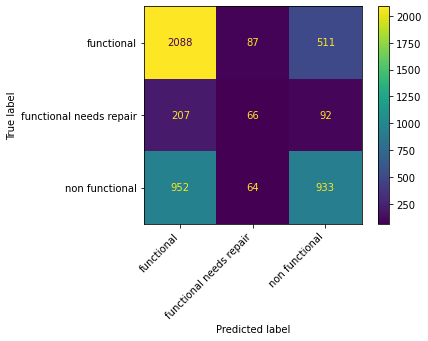

In [22]:
param_grid = {'knn__weights' : ['uniform']}
gs = do_gs(knn_clf_ns, param_grid)
gs_results.results_df()

The results are somewhat better using SMOTE.  We will continue iterating with SMOTE.

Best parameter (CV score=0.517):
                         precision    recall  f1-score   support

             functional       0.68      0.67      0.68      2686
functional needs repair       0.19      0.43      0.26       365
         non functional       0.65      0.50      0.56      1949

               accuracy                           0.59      5000
              macro avg       0.51      0.53      0.50      5000
           weighted avg       0.63      0.59      0.60      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111

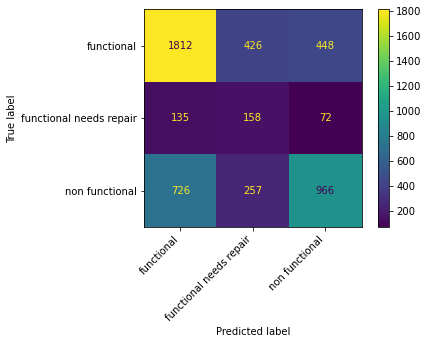

In [23]:
param_grid = {
    'knn__n_neighbors' : [2,4,6,8,10],
    'knn__p' : [1,2,3]
}

do_gs(knn_clf, param_grid)
gs_results.results_df()

Best parameter (CV score=0.524):
                         precision    recall  f1-score   support

             functional       0.70      0.63      0.66      2686
functional needs repair       0.20      0.48      0.28       365
         non functional       0.63      0.56      0.60      1949

               accuracy                           0.59      5000
              macro avg       0.51      0.56      0.51      5000
           weighted avg       0.64      0.59      0.61      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.523502

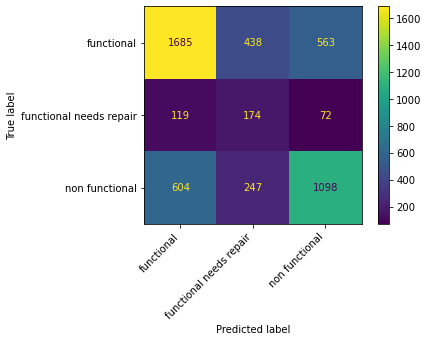

In [24]:
param_grid = {
    'knn__n_neighbors' : [5,6,7],
    'knn__p' : [1]
}
do_gs(knn_clf, param_grid)
gs_results.results_df()

Best parameter (CV score=0.516):
                         precision    recall  f1-score   support

             functional       0.70      0.64      0.66      2686
functional needs repair       0.19      0.45      0.27       365
         non functional       0.64      0.55      0.59      1949

               accuracy                           0.59      5000
              macro avg       0.51      0.55      0.51      5000
           weighted avg       0.64      0.59      0.61      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644

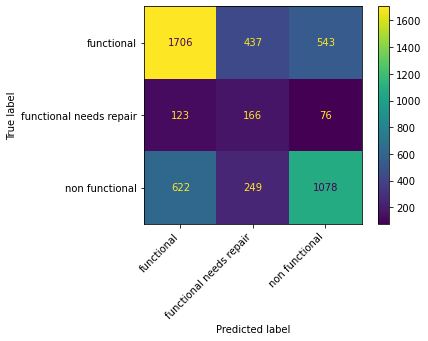

In [25]:
param_grid = {
    'knn__n_neighbors' : [5],
    'knn__p' : [1,1.1]
}

do_gs(knn_clf, param_grid)
gs_results.results_df()

Best parameter (CV score=0.526):
                         precision    recall  f1-score   support

             functional       0.70      0.64      0.67      2686
functional needs repair       0.20      0.47      0.28       365
         non functional       0.65      0.56      0.60      1949

               accuracy                           0.60      5000
              macro avg       0.52      0.56      0.52      5000
           weighted avg       0.64      0.60      0.62      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855

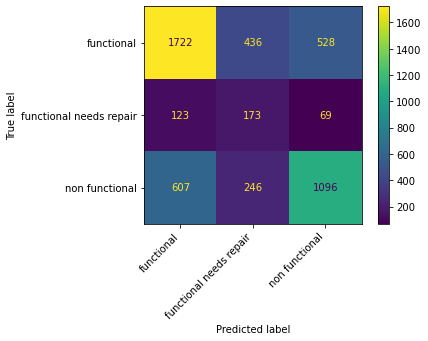

In [26]:
param_grid = {
    'knn__n_neighbors' : [5],
    'knn__p' : [1],
    'prep__cats__reduce__kw_args' : [{'t':.01, 'method':'percent'},
                                   {'t':.05, 'method':'percent'},
                                   {'t':.10, 'method':'percent'},
                                   {'t':10, 'method':'number'},
                                   {'t':50, 'method':'number'},
                                   {'t':100, 'method':'number'}]
}

do_gs(knn_clf, param_grid)
gs_results.results_df()

Best parameter (CV score=0.525):
                         precision    recall  f1-score   support

             functional       0.70      0.63      0.67      2686
functional needs repair       0.20      0.47      0.28       365
         non functional       0.65      0.56      0.60      1949

               accuracy                           0.60      5000
              macro avg       0.52      0.56      0.52      5000
           weighted avg       0.64      0.60      0.61      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482

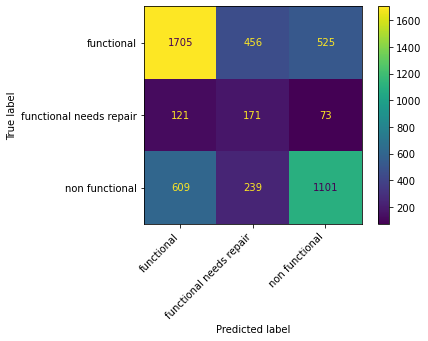

In [27]:
param_grid = {
    'knn__n_neighbors' : [5],
    'knn__p' : [1],
    'prep__cats__reduce__kw_args' : [{'t':40, 'method':'number'},
                                     {'t':50, 'method':'number'},
                                     {'t':60, 'method':'number'}]
}

do_gs(knn_clf, param_grid)
gs_results.results_df()

The hyper parameters on the cat vars aren't making a huge difference so we are going to move on to other models.

# DecisionTree

In [28]:
dt_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('dt', DecisionTreeClassifier())
])

dt_clf_ns = Pipeline(steps = [
    ('prep', ct),
    ('dt', DecisionTreeClassifier())
])

## With SMOTE

Best parameter (CV score=0.564):
                         precision    recall  f1-score   support

             functional       0.76      0.72      0.74      2686
functional needs repair       0.28      0.36      0.31       365
         non functional       0.70      0.71      0.70      1949

               accuracy                           0.69      5000
              macro avg       0.58      0.60      0.59      5000
           weighted avg       0.70      0.69      0.70      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473

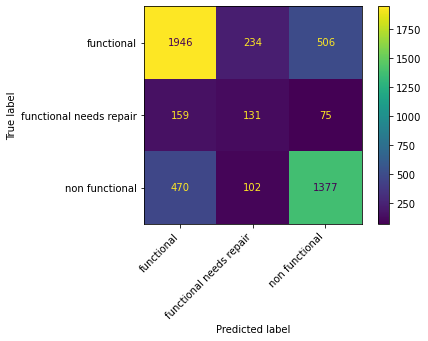

In [29]:
# Baseline Decision tree (likely overfit)

param_grid = {
}

model = do_gs(dt_clf, param_grid)
gs_results.results_df()


## Without SMOTE

Best parameter (CV score=0.569):
                         precision    recall  f1-score   support

             functional       0.74      0.72      0.73      2686
functional needs repair       0.28      0.33      0.30       365
         non functional       0.68      0.70      0.69      1949

               accuracy                           0.68      5000
              macro avg       0.57      0.58      0.57      5000
           weighted avg       0.69      0.68      0.68      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236

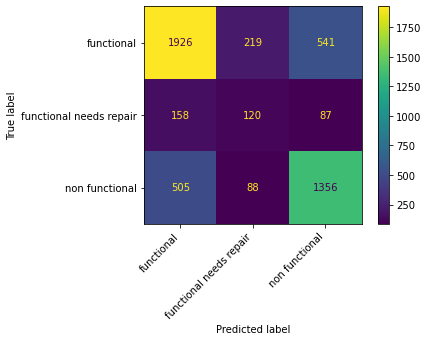

In [30]:
param_grid = {
    'dt__class_weight':['balanced']
}

model = do_gs(dt_clf_ns, param_grid)
gs_results.results_df()

Decision Tree is performing better with the class weight balanced and not using SMOTE.  We will iterate the rest of the DecisionTree models without SMOTE.

Best parameter (CV score=0.568):
                         precision    recall  f1-score   support

             functional       0.75      0.74      0.74      2686
functional needs repair       0.31      0.34      0.32       365
         non functional       0.71      0.71      0.71      1949

               accuracy                           0.70      5000
              macro avg       0.59      0.60      0.59      5000
           weighted avg       0.70      0.70      0.70      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862

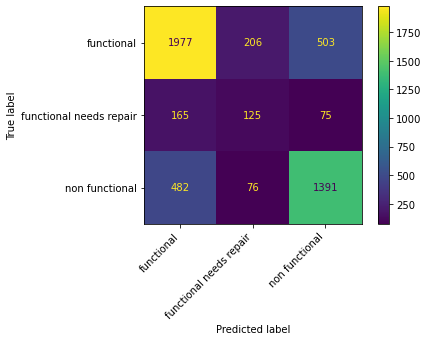

In [31]:
param_grid = {
    'dt__criterion' : ['gini', 'entropy'],
    'dt__max_depth' : [5, 10, 20, 30, 50]
}

last_model = model
model = do_gs(dt_clf_ns, param_grid)
gs_results.results_df()

In [32]:
# show only the new parameters
display_new_params(model, last_model)

dt__criterion  :  entropy
dt__max_depth  :  50


Best parameter (CV score=0.574):
                         precision    recall  f1-score   support

             functional       0.75      0.73      0.74      2686
functional needs repair       0.30      0.35      0.32       365
         non functional       0.70      0.71      0.71      1949

               accuracy                           0.69      5000
              macro avg       0.58      0.59      0.59      5000
           weighted avg       0.70      0.69      0.70      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783

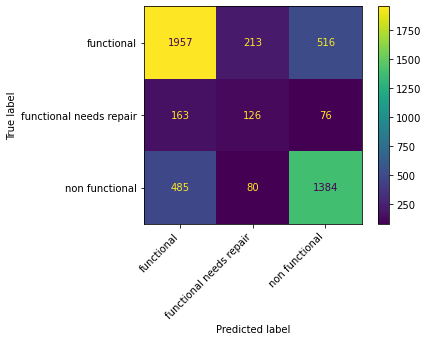

In [33]:
param_grid = {
    'dt__criterion' : ['entropy'],
    'dt__max_depth' : np.arange(25,35,1)
}

last_model = model
model = do_gs(dt_clf_ns, param_grid)
gs_results.results_df()

In [34]:
# show only the new parameters
display_new_params(model, last_model)

dt__max_depth  :  32


## Visualize

In [35]:
model.best_estimator_.predict(X_test)

array(['functional', 'functional', 'functional', ..., 'non functional',
       'functional', 'non functional'], dtype=object)

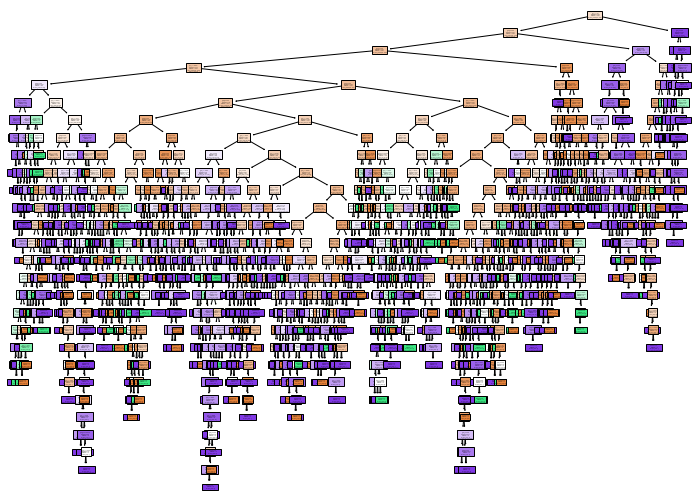

In [36]:
fig = plt.figure(figsize=(12,9))

model.best_estimator_[-1].__class__.__name__

_ = plot_tree(model.best_estimator_[-1],
                   class_names=y_small.unique(),
                   filled=True)


Best parameter (CV score=0.533):
                         precision    recall  f1-score   support

             functional       0.72      0.79      0.75      2686
functional needs repair       0.35      0.25      0.29       365
         non functional       0.71      0.64      0.67      1949

               accuracy                           0.69      5000
              macro avg       0.59      0.56      0.57      5000
           weighted avg       0.69      0.69      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878

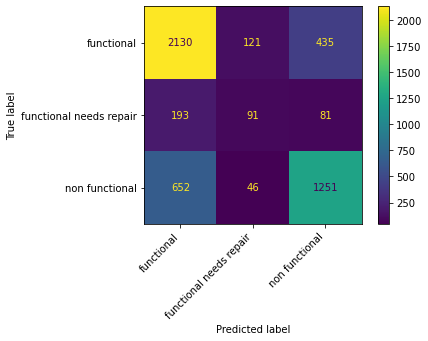

In [37]:
param_grid = {
    'dt__criterion' : ['entropy'],
    'dt__max_depth' : [36],
    'dt__min_samples_leaf': [10,20]
}

last_model = model
model = do_gs(dt_clf_ns, param_grid)
gs_results.results_df()

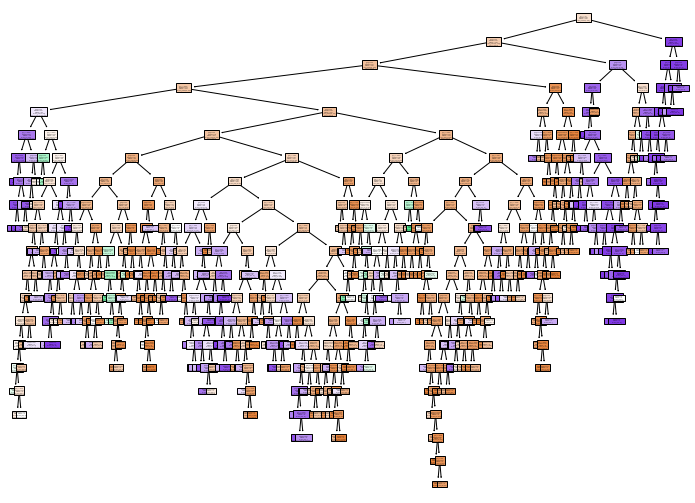

In [38]:
fig = plt.figure(figsize=(12,9))

model.best_estimator_[-1].__class__.__name__

_ = plot_tree(model.best_estimator_[-1],
                   class_names=y_small.unique(),
                   filled=True)


This looks pretty over fit and unbalanced.  We could continue pruning the tree but it may make more sense to move on to looking at a different model.

In [39]:
## Latitude and Longitude
latlong_cols = ['latitude', 'longitude']
latlong_pipeline_forvis = Pipeline(
        steps = [
            # Fill with median for now, will try other strategy in tuning
            ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
            ('imp-0', SimpleImputer(missing_values = -2e-08, strategy='median')),
            #('dt', DecisionTreeClassifier(criterion = 'entropy', max_depth=5))
        ])

X_forviz = latlong_pipeline_forvis.fit_transform(X[['latitude', 'longitude']], y)

dt_viz = DecisionTreeClassifier(criterion = 'entropy', max_depth=5).fit(X_forviz, y)

In [40]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    print(tree_)
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
tree_to_code(dt_viz, ['lat', 'long'])

def tree(lat, long):
  if long <= 30.30026626586914:
    if lat <= -4.846166610717773:
      if long <= 29.69472885131836:
        if lat <= -4.873434543609619:
          if long <= 29.68937110900879:
            return [[12.  0. 17.]]
          else:  # if long > 29.68937110900879
            return [[0. 0. 4.]]
        else:  # if lat > -4.873434543609619
          if long <= 29.63469886779785:
            return [[1. 0. 0.]]
          else:  # if long > 29.63469886779785
            return [[ 0.  1. 19.]]
      else:  # if long > 29.69472885131836
        if long <= 29.88996982574463:
          if lat <= -4.903987646102905:
            return [[14. 28. 33.]]
          else:  # if lat > -4.903987646102905
            return [[49. 38. 21.]]
        else:  # if long > 29.88996982574463
          if lat <= -4.8912599086761475:
            return [[27. 15. 28.]]
          else:  # if lat > -4.8912599086761475
            return [[ 0.  1. 27.]]
    else:  # if lat > -4.846166610717773
   

In [41]:
from sklearn import tree
print(tree.export_text(dt_viz, feature_names=['lat', 'long']))

|--- long <= 30.30
|   |--- lat <= -4.85
|   |   |--- long <= 29.69
|   |   |   |--- lat <= -4.87
|   |   |   |   |--- long <= 29.69
|   |   |   |   |   |--- class: non functional
|   |   |   |   |--- long >  29.69
|   |   |   |   |   |--- class: non functional
|   |   |   |--- lat >  -4.87
|   |   |   |   |--- long <= 29.63
|   |   |   |   |   |--- class: functional
|   |   |   |   |--- long >  29.63
|   |   |   |   |   |--- class: non functional
|   |   |--- long >  29.69
|   |   |   |--- long <= 29.89
|   |   |   |   |--- lat <= -4.90
|   |   |   |   |   |--- class: non functional
|   |   |   |   |--- lat >  -4.90
|   |   |   |   |   |--- class: functional
|   |   |   |--- long >  29.89
|   |   |   |   |--- lat <= -4.89
|   |   |   |   |   |--- class: non functional
|   |   |   |   |--- lat >  -4.89
|   |   |   |   |   |--- class: non functional
|   |--- lat >  -4.85
|   |   |--- long <= 29.77
|   |   |   |--- long <= 29.71
|   |   |   |   |--- long <= 29.64
|   |   |   |   |   |---

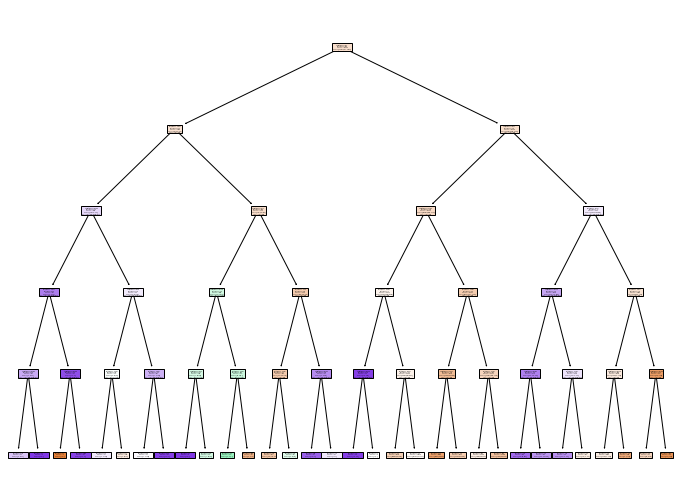

In [42]:
fig = plt.figure(figsize=(12,9))

dt_viz.__class__.__name__

_ = plot_tree(dt_viz,
              feature_names = ['latitude', 'longitude'],
              class_names=y_small.unique(),
              filled=True)


In [43]:
X_forviz.shape

(59400, 2)

In [44]:
le = LabelEncoder()
y_forviz = le.fit_transform(y_small)

In [45]:
class_names = le.inverse_transform([0,1,2])
class_names

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [48]:
import folium
import json

# Get the lat.long center of the map.  We have some 0 values so exclude those.
lat_center = (X.latitude[X['latitude'] != 0].max() + X['latitude'].min()) / 2
long_center = (X['longitude'].max() + X.longitude[X['longitude'] != 0].min()) / 2

lat_max = X.latitude.max()
lat_min = X.latitude.min()

long_max = X.longitude.max()
long_min = X.longitude.min()

with open('data/TZA_adm0_tanzanianzima.geojson', 'r') as jsonFile:
    tanzania_json = json.load(jsonFile)

m = folium.Map(location=(lat_center, long_center), zoom_start=6, tiles='OpenStreetMap',
              zoom_control=False)


folium.Choropleth(tanzania_json, fill_color='red').add_to(m)

points = [(lat_min, 37.51), (lat_max, 37.51)]
folium.PolyLine(points, popup='Node 1').add_to(m)

points = [(lat_min, 34.1), (lat_max, 34.1)]
folium.PolyLine(points, popup='Node 2').add_to(m)

points = [(lat_min, 30.29), (lat_max, 30.29)]
folium.PolyLine(points, popup='Node 3').add_to(m)

# node 4
points = [(-4.48, 34.1), (-4.48, 37.51)]
folium.PolyLine(points, popup='Node 4').add_to(m)

points = [(-8.13, 37.51), (-8.13, long_max)]
folium.PolyLine(points, popup='Node 5').add_to(m)

points = [(lat_min, 39.25), (-8.13, 39.25)]
folium.PolyLine(points, popup='Node 6').add_to(m)

points = [(-3.37, 37.51), (-3.37, long_max)]
folium.PolyLine(points, popup='Node 7').add_to(m)

# folium.Choropleth(
#     geo_data = region_json,                  #json
#     name ='choropleth',                  
#     data = df.groupby('region').count().reset_index(),                     
#     columns = ['region', 'status_group'], #columns to work on
#     key_on ='feature.properties.NAME_1',
#     fill_color ='YlGnBu',     #I passed colors Yellow,Green,Blue
#     fill_opacity = 0.7,
#     line_opacity = 0.2,
#     legend_name = "Number of pumps"
# ).add_to(m)

m

# Random Forest

In [50]:
rf_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('rf', RandomForestClassifier())
])

rf_clf_ns = Pipeline(steps = [
    ('prep', ct),
    ('rf', RandomForestClassifier())
])

## With SMOTE

Best parameter (CV score=0.601):
                         precision    recall  f1-score   support

             functional       0.75      0.85      0.80      2686
functional needs repair       0.41      0.36      0.38       365
         non functional       0.80      0.68      0.74      1949

               accuracy                           0.75      5000
              macro avg       0.65      0.63      0.64      5000
           weighted avg       0.75      0.75      0.74      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015

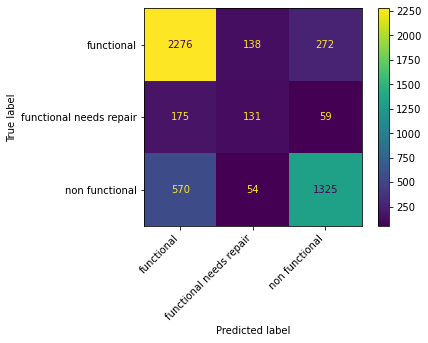

In [51]:
param_grid = {
     'smote__sampling_strategy':['auto'],
     'rf__criterion' : ['gini', 'entropy'],
     'rf__max_depth' : [5, 10, 15],
#    'min_samples_split': [5],
#    'min_samples_leaf': [10]
}

model = do_gs(rf_clf, param_grid)
gs_results.results_df()

## Without SMOTE

Best parameter (CV score=0.638):
                         precision    recall  f1-score   support

             functional       0.76      0.77      0.76      2686
functional needs repair       0.28      0.57      0.37       365
         non functional       0.83      0.65      0.73      1949

               accuracy                           0.71      5000
              macro avg       0.62      0.66      0.62      5000
           weighted avg       0.75      0.71      0.72      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477

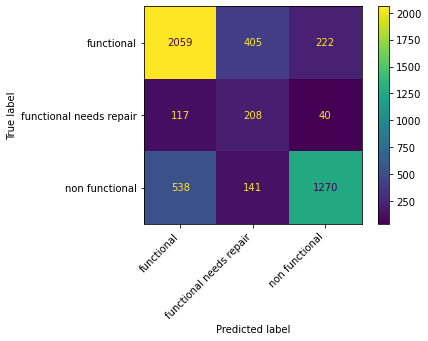

In [52]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__max_depth' : [5, 10, 15],
#    'min_samples_split': [5],
#    'min_samples_leaf': [10]
}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [53]:
# show only the new parameters
display_new_params(model, last_model)

rf__class_weight  :  balanced
rf__max_depth  :  10


Best parameter (CV score=0.641):
                         precision    recall  f1-score   support

             functional       0.76      0.72      0.73      2686
functional needs repair       0.25      0.58      0.34       365
         non functional       0.79      0.65      0.71      1949

               accuracy                           0.68      5000
              macro avg       0.60      0.65      0.60      5000
           weighted avg       0.73      0.68      0.70      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327

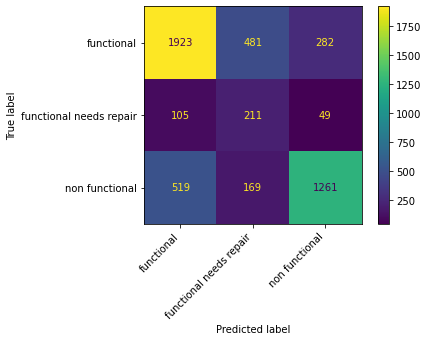

In [54]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [8,9,10,11,12],
#    'min_samples_split': [5],
    'rf__min_samples_leaf': [10, 20]
}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

Best parameter (CV score=0.641):
                         precision    recall  f1-score   support

             functional       0.74      0.71      0.73      2686
functional needs repair       0.24      0.61      0.34       365
         non functional       0.80      0.62      0.70      1949

               accuracy                           0.67      5000
              macro avg       0.60      0.65      0.59      5000
           weighted avg       0.73      0.67      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674

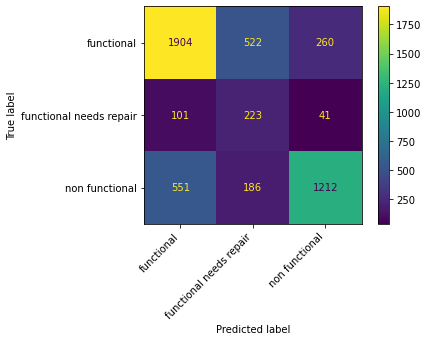

In [55]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
#    'min_samples_split': [5],
    'rf__min_samples_leaf': [8,9,10,11,12]
}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [56]:
# show only the new parameters
display_new_params(model, last_model)

rf__max_depth  :  10


Best parameter (CV score=0.643):
                         precision    recall  f1-score   support

             functional       0.75      0.69      0.72      2686
functional needs repair       0.24      0.62      0.34       365
         non functional       0.78      0.64      0.71      1949

               accuracy                           0.67      5000
              macro avg       0.59      0.65      0.59      5000
           weighted avg       0.73      0.67      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922

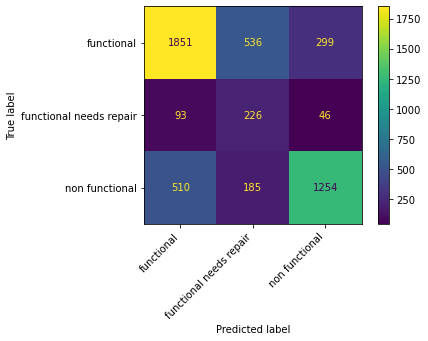

In [57]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
    'rf__min_samples_split': [20, 30, 40],
    'rf__min_samples_leaf': [8]
}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [58]:
# show only the new parameters
display_new_params(model, last_model)

rf__min_samples_leaf  :  8
rf__min_samples_split  :  30


Best parameter (CV score=0.642):
                         precision    recall  f1-score   support

             functional       0.75      0.71      0.73      2686
functional needs repair       0.24      0.60      0.34       365
         non functional       0.80      0.64      0.71      1949

               accuracy                           0.67      5000
              macro avg       0.60      0.65      0.59      5000
           weighted avg       0.73      0.67      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176

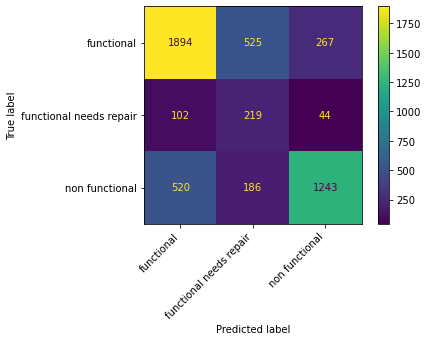

In [59]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
    'rf__min_samples_split': [20,21,25],  # below 20 risks overfitting
    'rf__min_samples_leaf': [8]
}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [60]:
# show only the new parameters
display_new_params(model, last_model)

rf__min_samples_split  :  21


In [61]:
# save for later
rf_model = model

# XGBoost

In [62]:
# for some reason this cannot be refit and needs to be reinitiated with each
# iteration

xgb_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

xgb_clf_ns = Pipeline(steps = [
    ('prep', ct),
    ('xg', XGBClassifier())
])

## With Smote

Best parameter (CV score=0.592):
                         precision    recall  f1-score   support

             functional       0.76      0.84      0.80      2686
functional needs repair       0.43      0.35      0.39       365
         non functional       0.78      0.70      0.74      1949

               accuracy                           0.75      5000
              macro avg       0.66      0.63      0.64      5000
           weighted avg       0.74      0.75      0.74      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383

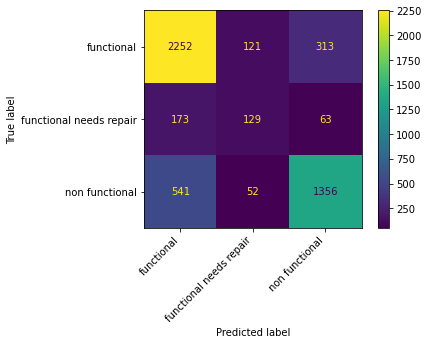

In [63]:
#IMBPipeline cannot be refit so we have to create a new every iteration
xgb_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

param_grid = {
    #'xg__learning_rate': [0.2],
    #'xg__max_depth': [6],
    #'xg__min_child_weight': [2],
    #'xg__subsample': [0.1],
    #'xg__n_estimators': [5],
    'xg__eval_metric': ['mlogloss'], # to supress warnings
    'smote__sampling_strategy':['auto']
}

model = do_gs(xgb_clf, param_grid)
gs_results.results_df()

## Without Smote

Best parameter (CV score=0.582):
                         precision    recall  f1-score   support

             functional       0.75      0.85      0.79      2686
functional needs repair       0.42      0.27      0.33       365
         non functional       0.79      0.69      0.74      1949

               accuracy                           0.75      5000
              macro avg       0.65      0.60      0.62      5000
           weighted avg       0.74      0.75      0.74      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180

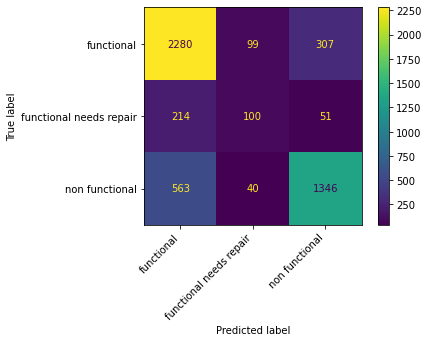

In [64]:
xgb_clf_ns = IMBPipeline(steps = [
    ('prep', ct),
    ('xg', XGBClassifier())
])

param_grid = {
    #'xg__learning_rate': [0.2],
    #'xg__max_depth': [6],
    #'xg__min_child_weight': [2],
    #'xg__subsample': [0.1],
    #'xg__n_estimators': [5],
    'xg__eval_metric': ['mlogloss'],
}

last_model = model
model = do_gs(xgb_clf_ns, param_grid)
gs_results.results_df()

XGBoost is performing better with SMOTE so we will iterate on the smote date.

Best parameter (CV score=0.599):
                         precision    recall  f1-score   support

             functional       0.75      0.83      0.79      2686
functional needs repair       0.40      0.37      0.38       365
         non functional       0.79      0.69      0.73      1949

               accuracy                           0.74      5000
              macro avg       0.65      0.63      0.63      5000
           weighted avg       0.74      0.74      0.74      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053

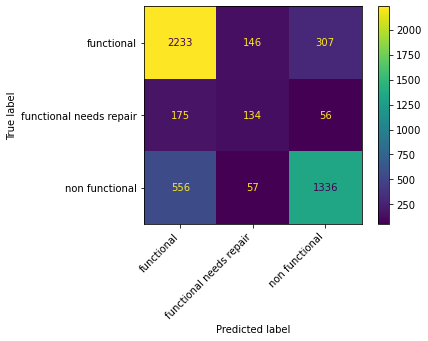

In [65]:
xgb_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

param_grid = {
    'xg__learning_rate': [0.1, 0.2],
    'xg__max_depth': [3,6,9],
    #'xg__min_child_weight': [2],
    #'xg__subsample': [0.1],
    'xg__n_estimators': [25,50,75],
    'xg__eval_metric': ['mlogloss'],
    'smote__sampling_strategy':['auto']
}

last_model = model
model = do_gs(xgb_clf, param_grid)
gs_results.results_df()

In [66]:
# show only the new parameters
display_new_params(model, last_model)

smote__sampling_strategy  :  auto
xg__learning_rate  :  0.1
xg__max_depth  :  9
xg__n_estimators  :  75


Best parameter (CV score=0.607):
                         precision    recall  f1-score   support

             functional       0.77      0.82      0.79      2686
functional needs repair       0.42      0.36      0.38       365
         non functional       0.77      0.72      0.74      1949

               accuracy                           0.74      5000
              macro avg       0.65      0.63      0.64      5000
           weighted avg       0.74      0.74      0.74      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286

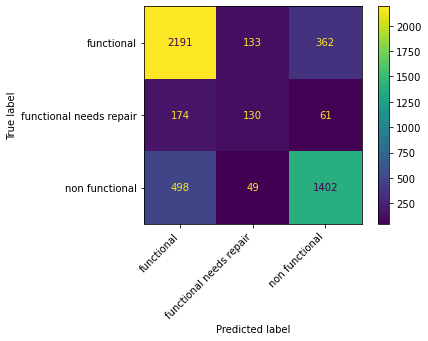

In [67]:
xgb_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

param_grid = {
    'xg__learning_rate': [0.2, 0.3],
    'xg__max_depth': [9,12,15],
    #'xg__min_child_weight': [2],
    #'xg__subsample': [0.1],
    'xg__n_estimators': [75,100,125],
    'xg__eval_metric': ['mlogloss'],
    'smote__sampling_strategy':['auto']
}

last_model = model
model = do_gs(xgb_clf, param_grid)
gs_results.results_df()

In [68]:
# show only the new parameters
display_new_params(model, last_model)

xg__learning_rate  :  0.2
xg__max_depth  :  15


Best parameter (CV score=0.605):
                         precision    recall  f1-score   support

             functional       0.76      0.81      0.79      2686
functional needs repair       0.39      0.34      0.36       365
         non functional       0.77      0.71      0.74      1949

               accuracy                           0.74      5000
              macro avg       0.64      0.62      0.63      5000
           weighted avg       0.74      0.74      0.74      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913

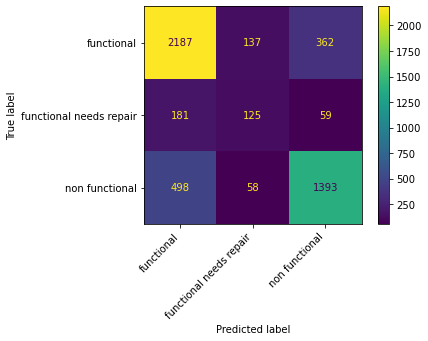

In [69]:
xgb_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

param_grid = {
    'xg__learning_rate': [0.2],
    'xg__max_depth': [15],
    #'xg__min_child_weight': [2],
    #'xg__subsample': [0.1],
    'xg__n_estimators': [125,150,200],
    'xg__eval_metric': ['mlogloss'],
    'smote__sampling_strategy':['auto']
}

last_model = model
model = do_gs(xgb_clf, param_grid)
gs_results.results_df()

In [70]:
# show only the new parameters
display_new_params(model, last_model)

xg__n_estimators  :  150


Best parameter (CV score=0.604):
                         precision    recall  f1-score   support

             functional       0.77      0.81      0.79      2686
functional needs repair       0.41      0.35      0.38       365
         non functional       0.77      0.72      0.74      1949

               accuracy                           0.74      5000
              macro avg       0.65      0.63      0.64      5000
           weighted avg       0.74      0.74      0.74      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754

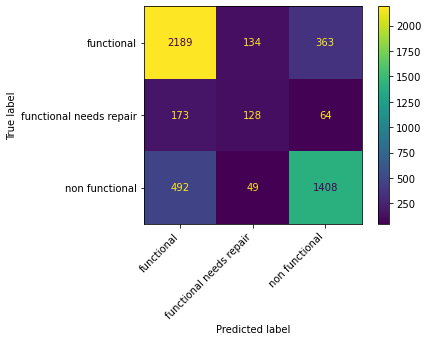

In [71]:
xgb_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

param_grid = {
    'xg__learning_rate': [0.2],
    'xg__max_depth': [15],
    'xg__min_child_weight': [5,10],
    'xg__subsample': [0.1,0.3,0.5,0.8],
    'xg__n_estimators': [125],
    'xg__eval_metric': ['mlogloss'],
    'smote__sampling_strategy':['auto']
}

last_model = model
model = do_gs(xgb_clf, param_grid)
gs_results.results_df()

XGBoost is still a long way from the quality of the Random Forest Model.  We will choose Random Forest as our final model further tune that a little.

# Random Forest Select
## Tune the pipeline

In [73]:
rf_model.best_params_

{'rf__class_weight': 'balanced',
 'rf__criterion': 'entropy',
 'rf__max_depth': 10,
 'rf__min_samples_leaf': 8,
 'rf__min_samples_split': 21}

Best parameter (CV score=0.641):
                         precision    recall  f1-score   support

             functional       0.75      0.71      0.73      2686
functional needs repair       0.23      0.58      0.33       365
         non functional       0.80      0.63      0.71      1949

               accuracy                           0.67      5000
              macro avg       0.59      0.64      0.59      5000
           weighted avg       0.73      0.67      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754
RandomForestClassifier(prep__cont__imp__strateg...  0.640997

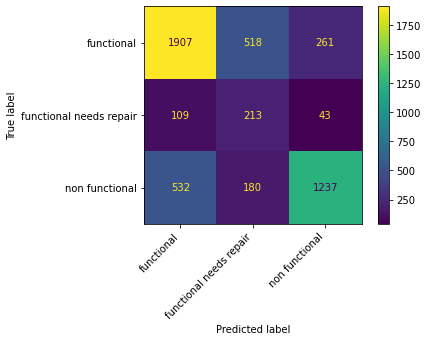

In [74]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
    'rf__min_samples_split': [21],
    'rf__min_samples_leaf': [8],

    'prep__cont__imp__strategy':['median','mean'],
    
    'prep__pop__imp1__missing_values':[1],
    'prep__pop__imp1__strategy':['constant'],
    'prep__pop__imp1__fill_value':[0, 1],
    
    'prep__pop__imp0__missing_values':[0],
    'prep__pop__imp0__strategy':['median','mean']
    
#    'prep__latlong'
#    'prep__log'
#    'prep__cats'
#    'prep__bool'
#    'prep__date'
}

last_model = rf_model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [75]:
# show only the new parameters
display_new_params(model, last_model)

prep__cont__imp__strategy  :  mean
prep__pop__imp0__missing_values  :  0
prep__pop__imp0__strategy  :  median
prep__pop__imp1__fill_value  :  0
prep__pop__imp1__missing_values  :  1
prep__pop__imp1__strategy  :  constant


Best parameter (CV score=0.646):
                         precision    recall  f1-score   support

             functional       0.75      0.71      0.73      2686
functional needs repair       0.23      0.59      0.33       365
         non functional       0.80      0.63      0.71      1949

               accuracy                           0.67      5000
              macro avg       0.60      0.64      0.59      5000
           weighted avg       0.73      0.67      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754
RandomForestClassifier(prep__cont__imp__strateg...  0.640997
RandomForestClassifier(prep__cont__imp__strateg...  0.645645

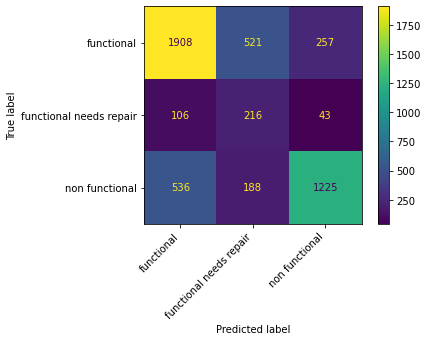

In [76]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
    'rf__min_samples_split': [21],
    'rf__min_samples_leaf': [8],

    'prep__cont__imp__strategy':['mean'],
    
    # ('imp1', SimpleImputer(missing_values = 1, strategy='constant', fill_value=0)),    
    'prep__pop__imp1__missing_values':[1],
    'prep__pop__imp1__strategy':['constant'],
    'prep__pop__imp1__fill_value':[0],
    
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__pop__imp0__missing_values':[0],
    'prep__pop__imp0__strategy':['median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__pop__log__func':[np.log, None],
                
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__latlong__imp0__missing_values':[0],
    'prep__latlong__imp0__strategy':['mean', 'median', 'constant'],
    'prep__latlong__imp0__fill_value':[0],
    
    #('imp-0', SimpleImputer(missing_values = -2e-08, strategy='median'))
    'prep__latlong__imp-0__missing_values':[-2e-08],
    'prep__latlong__imp-0__strategy':['mean', 'median', 'constant'],
    'prep__latlong__imp-0__fill_value':[0]
    
#    'prep__log'
#    'prep__cats'
#    'prep__bool'
#    'prep__date'
}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [77]:
# show only the new parameters
display_new_params(model, last_model)

prep__latlong__imp-0__fill_value  :  0
prep__latlong__imp-0__missing_values  :  -2e-08
prep__latlong__imp-0__strategy  :  median
prep__latlong__imp0__fill_value  :  0
prep__latlong__imp0__missing_values  :  0
prep__latlong__imp0__strategy  :  median
prep__pop__log__func  :  <ufunc 'log'>


Best parameter (CV score=0.635):
                         precision    recall  f1-score   support

             functional       0.75      0.68      0.72      2686
functional needs repair       0.23      0.59      0.33       365
         non functional       0.78      0.65      0.71      1949

               accuracy                           0.66      5000
              macro avg       0.59      0.64      0.58      5000
           weighted avg       0.73      0.66      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754
RandomForestClassifier(prep__cont__imp__strateg...  0.640997
RandomForestClassifier(prep__cont__imp__strateg...  0.645645
RandomForestClassifier(prep__cont__imp__strateg...  0.635111

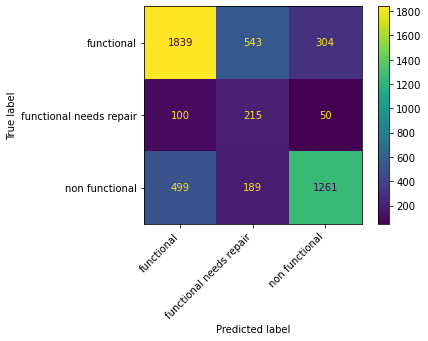

In [78]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
    'rf__min_samples_split': [21],
    'rf__min_samples_leaf': [8],

    'prep__cont__imp__strategy':['mean'],
    
    # ('imp1', SimpleImputer(missing_values = 1, strategy='constant', fill_value=0)),    
    'prep__pop__imp1__missing_values':[1],
    'prep__pop__imp1__strategy':['constant'],
    'prep__pop__imp1__fill_value':[0],
    
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__pop__imp0__missing_values':[0],
    'prep__pop__imp0__strategy':['median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__pop__log__func':[None],
                
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__latlong__imp0__missing_values':[0],
    'prep__latlong__imp0__strategy':['median'],
    'prep__latlong__imp0__fill_value':[0],
    
    #('imp-0', SimpleImputer(missing_values = -2e-08, strategy='median'))
    'prep__latlong__imp-0__missing_values':[-2e-08],
    'prep__latlong__imp-0__strategy':['median'],
    
    # ('imp', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__log__imp__missing_values':[0],
    'prep__log__imp__strategy':['mean'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__log__log__func': [None]
 
#    'prep__bool'

#    'prep__date'

#    'prep__cats'


}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

Best parameter (CV score=0.644):
                         precision    recall  f1-score   support

             functional       0.75      0.70      0.73      2686
functional needs repair       0.23      0.58      0.33       365
         non functional       0.79      0.64      0.71      1949

               accuracy                           0.67      5000
              macro avg       0.59      0.64      0.59      5000
           weighted avg       0.73      0.67      0.69      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754
RandomForestClassifier(prep__cont__imp__strateg...  0.640997
RandomForestClassifier(prep__cont__imp__strateg...  0.645645
RandomForestClassifier(prep__cont__imp__strateg...  0.635111
RandomForestClassifier(prep__cont__imp__strateg...  0.644206

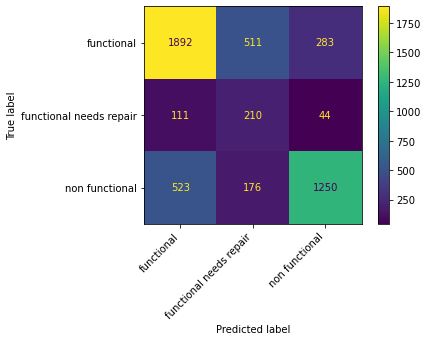

In [79]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
    'rf__min_samples_split': [21],
    'rf__min_samples_leaf': [8],

    'prep__cont__imp__strategy':['mean'],
    
    # ('imp1', SimpleImputer(missing_values = 1, strategy='constant', fill_value=0)),    
    'prep__pop__imp1__missing_values':[1],
    'prep__pop__imp1__strategy':['constant'],
    'prep__pop__imp1__fill_value':[0],
    
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__pop__imp0__missing_values':[0],
    'prep__pop__imp0__strategy':['median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__pop__log__func':[None],
                
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__latlong__imp0__missing_values':[0],
    'prep__latlong__imp0__strategy':['median'],
    'prep__latlong__imp0__fill_value':[0],
    
    #('imp-0', SimpleImputer(missing_values = -2e-08, strategy='median'))
    'prep__latlong__imp-0__missing_values':[-2e-08],
    'prep__latlong__imp-0__strategy':['median'],
    
    # ('imp', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__log__imp__missing_values':[0],
    'prep__log__imp__strategy':['mean', 'median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__log__log__func': [np.log, None],

    #('date', DatePrep(strategy = 'median'))
    'prep__date__date__strategy': ['mean', 'median', 'max', 'min']

    # ('reduce', FunctionTransformer(func = filter_top_cats, 
    #                                       kw_args={'t':.05, 'method':'percent'}))
    #'prep__cats__reduce__func': [filter_top_cats],
    #'prep__cats__kw_args'{'t':.05, 'method':'percent'}:


}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [80]:
# show only the new parameters
display_new_params(model, last_model)

prep__date__date__strategy  :  min


Best parameter (CV score=0.647):
                         precision    recall  f1-score   support

             functional       0.75      0.72      0.73      2686
functional needs repair       0.24      0.58      0.34       365
         non functional       0.80      0.64      0.71      1949

               accuracy                           0.68      5000
              macro avg       0.60      0.65      0.60      5000
           weighted avg       0.73      0.68      0.70      5000



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754
RandomForestClassifier(prep__cont__imp__strateg...  0.640997
RandomForestClassifier(prep__cont__imp__strateg...  0.645645
RandomForestClassifier(prep__cont__imp__strateg...  0.635111
RandomForestClassifier(prep__cont__imp__strateg...  0.644206
RandomForestClassifier(prep__cats__reduce__func...  0.647258

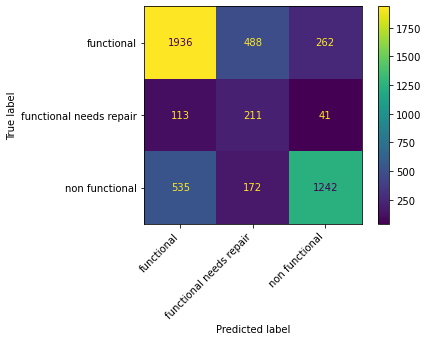

In [81]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [10],
    'rf__min_samples_split': [21],
    'rf__min_samples_leaf': [8],

    'prep__cont__imp__strategy':['mean'],
    
    # ('imp1', SimpleImputer(missing_values = 1, strategy='constant', fill_value=0)),    
    'prep__pop__imp1__missing_values':[1],
    'prep__pop__imp1__strategy':['constant'],
    'prep__pop__imp1__fill_value':[0],
    
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__pop__imp0__missing_values':[0],
    'prep__pop__imp0__strategy':['median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__pop__log__func':[None],
                
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__latlong__imp0__missing_values':[0],
    'prep__latlong__imp0__strategy':['median'],
    'prep__latlong__imp0__fill_value':[0],
    
    #('imp-0', SimpleImputer(missing_values = -2e-08, strategy='median'))
    'prep__latlong__imp-0__missing_values':[-2e-08],
    'prep__latlong__imp-0__strategy':['median'],
    
    # ('imp', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__log__imp__missing_values':[0],
    'prep__log__imp__strategy':['median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__log__log__func': [None],

    #('date', DatePrep(strategy = 'median'))
    'prep__date__date__strategy': ['mean'],

    # ('reduce', FunctionTransformer(func = filter_top_cats, 
    #                                       kw_args={'t':.05, 'method':'percent'}))
    'prep__cats__reduce__func': [filter_top_cats],
    'prep__cats__reduce__kw_args':[{'t':.01, 'method':'percent'},
                                   {'t':.05, 'method':'percent'},
                                   {'t':.10, 'method':'percent'},
                                   {'t':.20, 'method':'percent'}]

}

last_model = model
model = do_gs(rf_clf_ns, param_grid)
gs_results.results_df()

In [82]:
# show only the new parameters
display_new_params(model, last_model)

prep__cats__reduce__func  :  <function filter_top_cats at 0x124dd7550>
prep__cats__reduce__kw_args  :  {'t': 0.05, 'method': 'percent'}
prep__date__date__strategy  :  mean
prep__log__imp__strategy  :  median


## Final Model

We now have our optimum parameters on the reduced dataset.  Test the performance of the model on the full dataset.  Here I modified the parameters that looked suspect to verify that they still perform on the full dataset.

In [83]:
model.best_params_

{'prep__cats__reduce__func': <function helpers.filter_top_cats(array, t=5, method='number')>,
 'prep__cats__reduce__kw_args': {'t': 0.05, 'method': 'percent'},
 'prep__cont__imp__strategy': 'mean',
 'prep__date__date__strategy': 'mean',
 'prep__latlong__imp-0__missing_values': -2e-08,
 'prep__latlong__imp-0__strategy': 'median',
 'prep__latlong__imp0__fill_value': 0,
 'prep__latlong__imp0__missing_values': 0,
 'prep__latlong__imp0__strategy': 'median',
 'prep__log__imp__missing_values': 0,
 'prep__log__imp__strategy': 'median',
 'prep__log__log__func': None,
 'prep__pop__imp0__missing_values': 0,
 'prep__pop__imp0__strategy': 'median',
 'prep__pop__imp1__fill_value': 0,
 'prep__pop__imp1__missing_values': 1,
 'prep__pop__imp1__strategy': 'constant',
 'prep__pop__log__func': None,
 'rf__class_weight': 'balanced',
 'rf__criterion': 'entropy',
 'rf__max_depth': 10,
 'rf__min_samples_leaf': 8,
 'rf__min_samples_split': 21}

In [84]:
# Train test split for visulazation and metrics
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.2,
                                                    random_state=594)

Best parameter (CV score=0.687):
                         precision    recall  f1-score   support

             functional       0.79      0.70      0.74      6434
functional needs repair       0.25      0.75      0.38       886
         non functional       0.84      0.65      0.74      4560

               accuracy                           0.69     11880
              macro avg       0.63      0.70      0.62     11880
           weighted avg       0.77      0.69      0.71     11880



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754
RandomForestClassifier(prep__cont__imp__strateg...  0.640997
RandomForestClassifier(prep__cont__imp__strateg...  0.645645
RandomForestClassifier(prep__cont__imp__strateg...  0.635111
RandomForestClassifier(prep__cont__imp__strateg...  0.644206
RandomForestClassifier(prep__cats__reduce__func...  0.647258
RandomForestClassifier(prep__cats__reduce__func...  0.687124

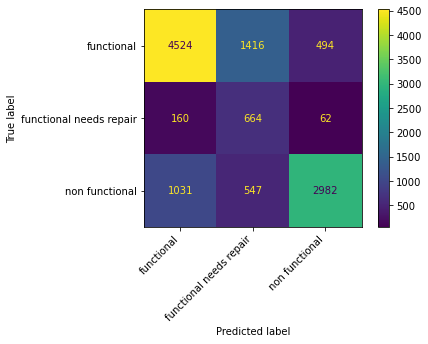

In [85]:
param_grid = {
    'rf__class_weight': ['balanced'],
    'rf__criterion' : ['entropy'],
    'rf__max_depth' : [9,10,11],
    'rf__min_samples_split': [21],
    'rf__min_samples_leaf': [9],

    'prep__cont__imp__strategy':['mean', 'median'],
    
    # ('imp1', SimpleImputer(missing_values = 1, strategy='constant', fill_value=0)),    
    'prep__pop__imp1__missing_values':[1],
    'prep__pop__imp1__strategy':['constant'],
    'prep__pop__imp1__fill_value':[0],
    
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__pop__imp0__missing_values':[0],
    'prep__pop__imp0__strategy':['mean', 'median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__pop__log__func':[np.log, None],
                
    # ('imp0', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__latlong__imp0__missing_values':[0],
    'prep__latlong__imp0__strategy':['median'],
    
    #('imp-0', SimpleImputer(missing_values = -2e-08, strategy='median'))
    'prep__latlong__imp-0__missing_values':[-2e-08],
    'prep__latlong__imp-0__strategy':['mean', 'median'],
    
    # ('imp', SimpleImputer(missing_values = 0, strategy='median')),
    'prep__log__imp__missing_values':[0],
    'prep__log__imp__strategy':['median'],
    
    # ('log', FunctionTransformer(np.log))
    'prep__log__log__func': [None],

    #('date', DatePrep(strategy = 'median'))
    'prep__date__date__strategy': ['mean', 'median'],

    # ('reduce', FunctionTransformer(func = filter_top_cats, 
    #                                       kw_args={'t':.05, 'method':'percent'}))
    'prep__cats__reduce__func': [filter_top_cats],
    'prep__cats__reduce__kw_args':[{'t':.05, 'method':'percent'}]
}

last_model = model
model = do_gs(rf_clf_ns, param_grid, X=X_train, y=y_train)
gs_results.results_df()

In [86]:
display_new_params(model, last_model)

prep__cont__imp__strategy  :  median
prep__date__date__strategy  :  median
prep__latlong__imp-0__strategy  :  mean
prep__pop__imp0__strategy  :  mean
rf__max_depth  :  11
rf__min_samples_leaf  :  9


## Double check against XGBoost

Best parameter (CV score=0.675):
                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      6434
functional needs repair       0.46      0.45      0.46       886
         non functional       0.82      0.78      0.80      4560

               accuracy                           0.79     11880
              macro avg       0.70      0.69      0.69     11880
           weighted avg       0.79      0.79      0.79     11880



score
KNeighborsClassifier()                              0.485772
KNeighborsClassifier(knn__weights = uniform)        0.439856
KNeighborsClassifier(knn__n_neighbors = 6, knn_...  0.517111
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.515644
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525855
KNeighborsClassifier(knn__n_neighbors = 5, knn_...  0.525482
DecisionTreeClassifier()                            0.564473
DecisionTreeClassifier(dt__class_weight = balan...  0.569236
DecisionTreeClassifier(dt__criterion = entropy,...  0.567862
DecisionTreeClassifier(dt__criterion = entropy,...  0.573783
DecisionTreeClassifier(dt__criterion = entropy,...  0.532878
RandomForestClassifier(rf__criterion = entropy,...  0.601015
RandomForestClassifier(rf__class_weight = balan...  0.638477
RandomForestClassifier(rf__class_weight = balan...  0.641327
RandomForestClassifier(rf__class_weight = balan...  0.640674
RandomForestClassifier(rf__class_weight = balan...  0.642922
RandomForestClassifier(rf__class_weight = balan...  0.642176
XGBClassifier(smote__sampling_strategy = auto, ...  0.592383
XGBClassifier(xg__eval_metric = mlogloss)           0.582180
XGBClassifier(smote__sampling_strategy = auto, ...  0.599053
XGBClassifier(smote__sampling_strategy = auto, ...  0.607286
XGBClassifier(smote__sampling_strategy = auto, ...  0.604913
XGBClassifier(smote__sampling_strategy = auto, ...  0.603754
RandomForestClassifier(prep__cont__imp__strateg...  0.640997
RandomForestClassifier(prep__cont__imp__strateg...  0.645645
RandomForestClassifier(prep__cont__imp__strateg...  0.635111
RandomForestClassifier(prep__cont__imp__strateg...  0.644206
RandomForestClassifier(prep__cats__reduce__func...  0.647258
RandomForestClassifier(prep__cats__reduce__func...  0.687124
XGBClassifier(smote__sampling_strategy = auto, ...  0.675008

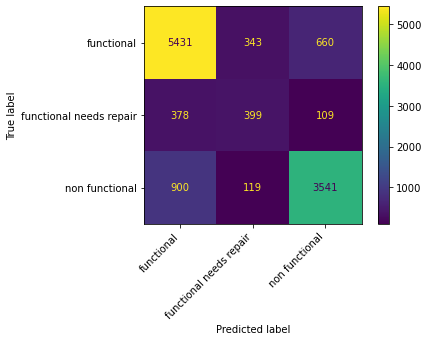

In [87]:
#try with larger data
xgb_clf = IMBPipeline(steps = [
    ('prep', ct),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

param_grid = {
    'xg__learning_rate': [0.2],
    'xg__max_depth': [15],
    'xg__min_child_weight': [5],
    'xg__subsample': [0.3],
    'xg__n_estimators': [125],
    'xg__eval_metric': ['mlogloss'],
    'smote__sampling_strategy':['auto']
}

last_model = model
model = do_gs(xgb_clf, param_grid, X=X_train, y=y_train)
gs_results.results_df()

# Visualize Final Model

## Confustion Marix

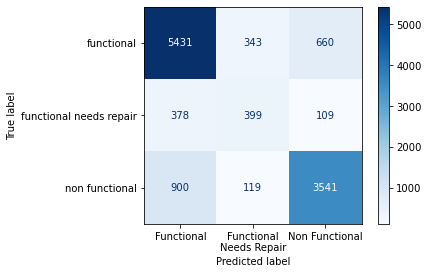

In [88]:
plot_confusion_matrix(model, X_test, y_test, cmap='Blues')
plt.xticks([0,1,2], ['Functional', 'Functional\nNeeds Repair', 'Non Functional']);

## Tree

In [89]:
# pull out the model
rf = model.best_estimator_[-1]

# pick a random tree from the forrest
clf = rf.estimators_[29]

#plot the tree
fig = plt.figure(figsize=(12,9))
_ = plot_tree(clf,
              class_names=y.unique(),
              filled=True)


AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

This tree looks reasonably balanced.

In [ ]:
# plot only the top 3 splits for presentation

fig = plt.figure(figsize=(6,6))
model.best_estimator_[-1].__class__.__name__

_ = plot_tree(clf, class_names=y.unique(),
              filled=True, max_depth=3)

## [TO DO] Visualize Feature Importance

In [ ]:
# Recreate feature names
feature_names = get_feature_names(ct)
feature_names[-1] = 'years_since_construction'

In [ ]:
# Capitolize feature names
cat_cols_caps = [x.replace('_', ' ').capitalize() for x in cat_cols]

In [ ]:
# Create a name map to replace x values in feature names
replace_dict = {}

for n, col in enumerate(cat_cols_caps):
    replace_dict['x'+str(n)] = col
    
replace_dict

In [ ]:
feature_names_tx = []

for name in feature_names:
    name = name.split('__')[-1]
    if name.startswith('x'):
        idx, suffix = name.split('_')
        idx = idx[1:]
        
        name = cat_cols_caps[int(idx)] + ': ' + suffix
    else:
        name = name.replace('_', ' ').title()
    
    feature_names_tx.append(name)
    
feature_names_tx

In [ ]:
std = np.std([tree.feature_importances_ for tree in model.best_estimator_[-1].estimators_],
             axis=0)
std

importances = model.best_estimator_[-1].feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
import matplotlib.ticker as mtick


# # Build a classification task using 3 informative features
# X, y = make_classification(n_samples=1000,
#                            n_features=10,
#                            n_informative=3,
#                            n_redundant=0,
#                            n_repeated=0,
#                            n_classes=2,
#                            random_state=0,
#                            shuffle=False)

# # Build a forest and compute the impurity-based feature importances
# forest = ExtraTreesClassifier(n_estimators=250,
#                               random_state=0)

# forest.fit(X, y)

forest = model.best_estimator_[-1]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(len(feature_names_tx)):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest


with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1.4):
    fig = plt.figure(figsize=(10, 6))
    plt.title("Feature importances")

    num_results = 8
    plt.barh(range(num_results), importances[indices][:num_results],
            color="#66a5bb", yerr=std[indices][:num_results], align="center",)

    ordered_names = [feature_names_tx[x] for x in indices]
    plt.yticks(range(len(feature_names_tx[:num_results])), ordered_names[:num_results])
    plt.ylim([-1, len(feature_names_tx[:num_results])])
    
    plt.xlabel('Relative importance')
    
    ax = plt.gca()
    ax.invert_yaxis()

    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    
    fig.set_facecolor('None')
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.set_facecolor('None')
    
    # Show as percent
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

    plt.show()

# lessons learned

Unless the dataset is very small, optimizing for cross validation may just result in runtimes that are impractical. Also IMBlearn's pipeline doesn't play nicely with sklean's for anything other than prediction.

If you are visualizing results IMBlearn's Pipline makes getting feature names even more difficult than with sklearn.

would be better It would be a better use of time to incorporate SMOTE or other resampling techniques into the pipeline model iteration if visualization of the results is going to be necessary.  Alternatively I could use grid search's multi metric tracking and generate results from that.
